# Heat equation - Retrieving operator through ODE solving

In [268]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")

Main.Models

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well different methods to study their efficiency with regards to the stability of the equation (explicit, implicit finite-difference, finite-element, pseudo-spectral)

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with a pseudo-spectral form using FFRT, a numerically stable solution for a large range of parameters.

In [2]:
t_max = 1.;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

typ = 3;
d = 1.;
k = 1.;
kappa = 0.005;
L = x_max - x_min
c = [0.7, 0.3, 0.4];
n = [3, 7, 10];

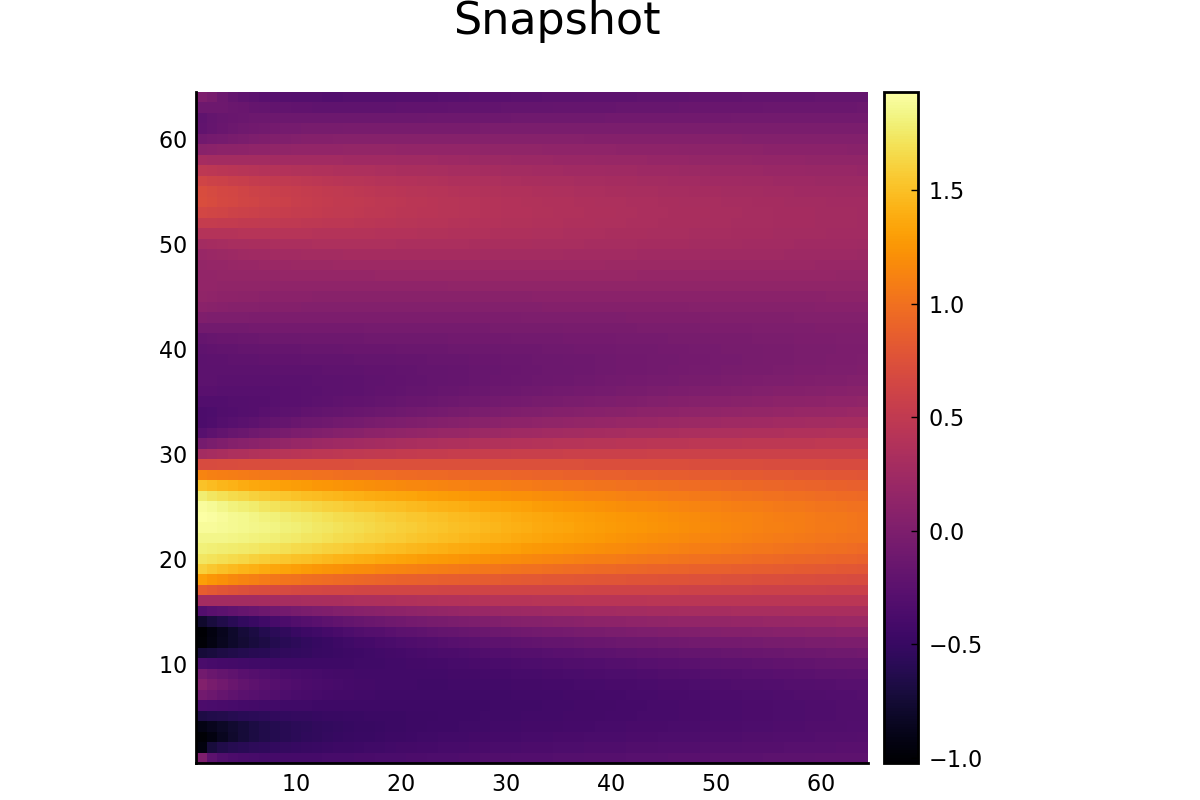

In [16]:
dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

# u0 = InitialFunctions.heat_analytical_init(t, x, n, c, kappa);
# u0 = InitialFunctions.high_dim_random_init(t, x);
t, u = Equations.get_heat_fft(t, dx, x_n, kappa, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

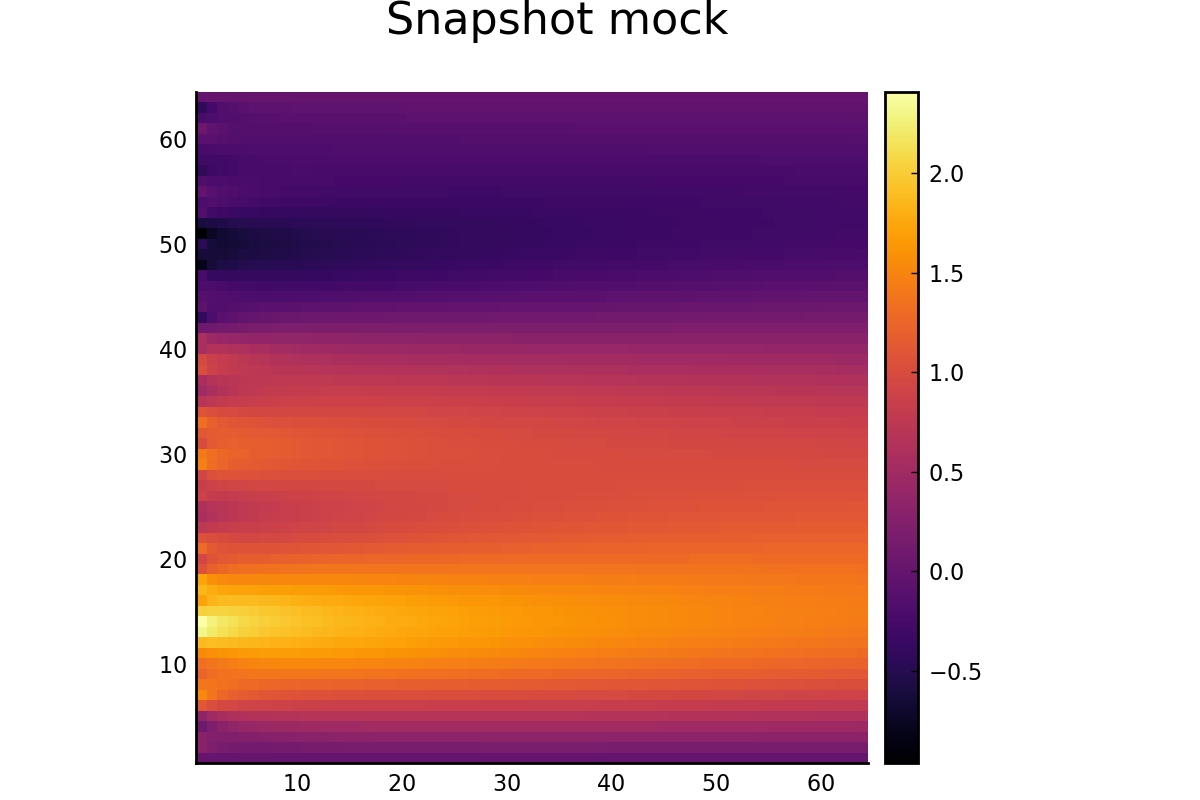

In [4]:
ta, u_a = Generator.heat_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, 4, kappa, k)
GraphicTools.show_state(u_a, "Snapshot mock")

## Generate dataset

In [5]:
function create_solution(c, k, ka)
    X(k, x) = sqrt(2 / L) * sin(pi * k * (x - x_min) / L)
    u(x, t) = sum(c * exp(-ka * (pi * k / L)^2 * t) * X(k, x) for (c, k) in zip(c, k))
    u
end

create_solution (generic function with 1 method)

In [69]:
function syver_cond(t_max, t_min, x_max, x_min, t_n, x_n, ka, nsample) 
    tsnap = LinRange(t_min, t_max, t_n)# [2:end]
    K = 50
    k = 1:K
    c = [randn(K) ./ k for _ = 1:nsample]
    u = [create_solution(c, k, ka) for c ∈ c]
    init = [u(x, 0.) for x ∈ x, u ∈ u]
    train = [u(x, t) for x ∈ x, u ∈ u, t ∈ tsnap]
    return tsnap, init, train
end

syver_cond (generic function with 1 method)

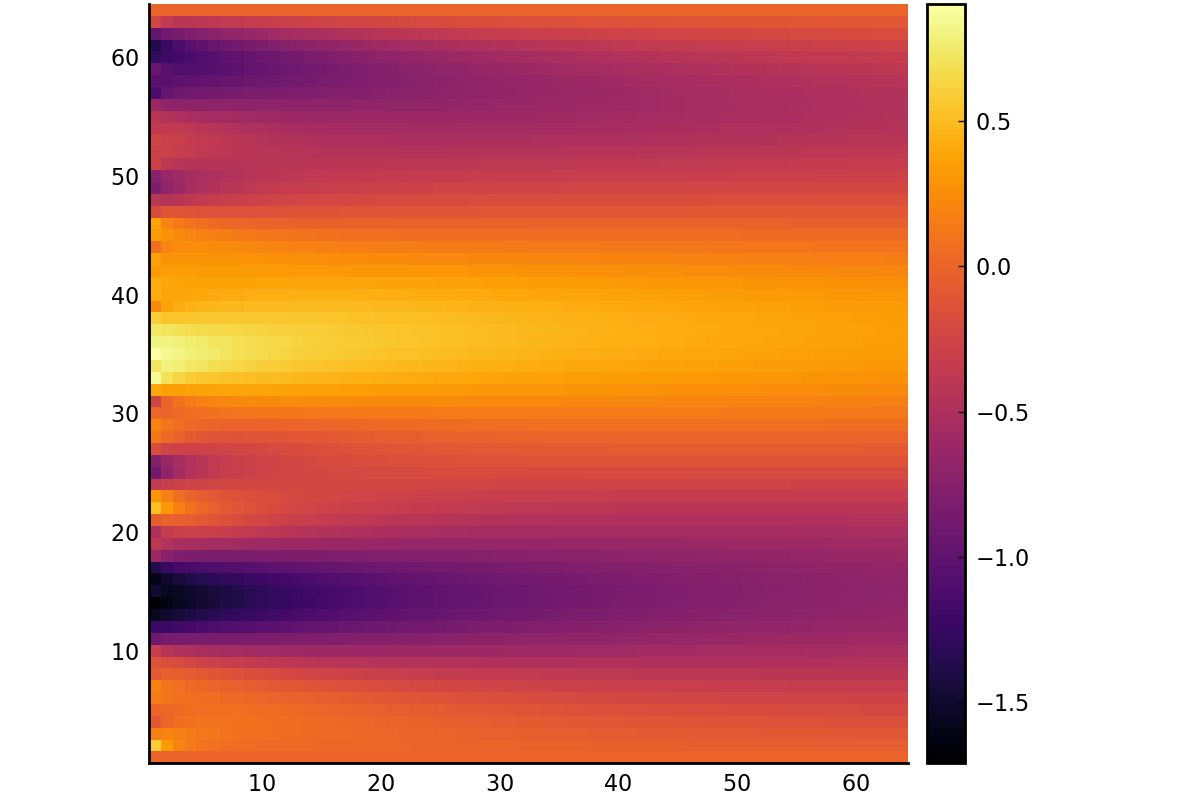

In [70]:
res = InitialFunctions.analytical_heat_1d(t, x, 1:50, [], kappa);
GraphicTools.show_state(res, "")

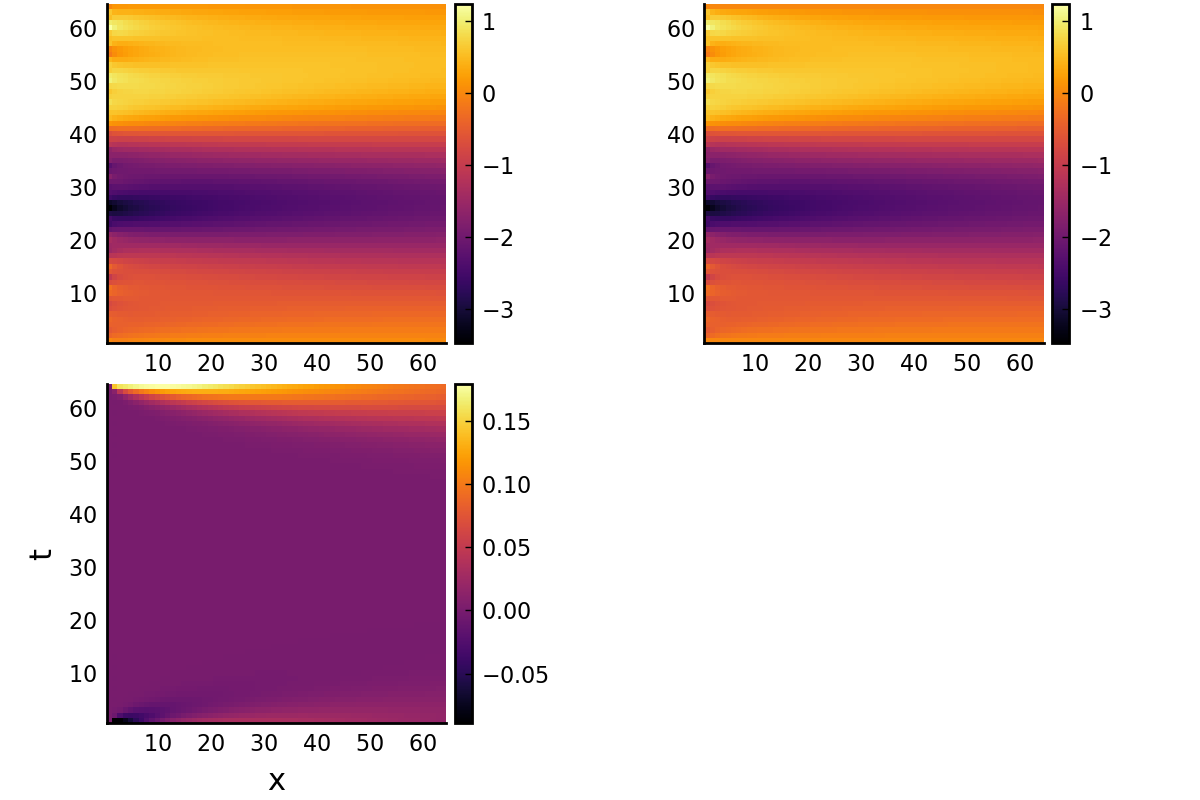

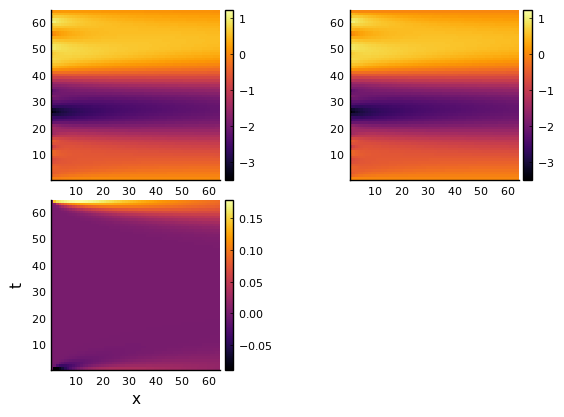

In [54]:
syver_dataset = syver_cond(t_max, t_min, x_max, x_min, t_n, x_n, kappa, 2);
t, init_set, true_set = syver_dataset;
_, u = Equations.get_heat_fft(t, dx, x_n, kappa, init_set[:, 1]);
display(
    plot(
        GraphicTools.show_state(u, ""), # need to reverse u, odesolver switch dimensions
        GraphicTools.show_state(true_set[:, 1, :], ""),
        GraphicTools.show_err(u, true_set[:, 1, :], "");
    );
);

In [154]:
# dataset = Generator.generate_heat_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, 200, 4, kappa, k, "./src/dataset/hand_analytical_heat_training_set.jld2", "training_set");
hand_dataset = Generator.read_dataset("./src/dataset/hand_analytical_heat_training_set.jld2")["training_set"];
analytic_dataset = Generator.read_dataset("./src/dataset/odesolver_analytical_heat_training_set.jld2")["training_set"];
high_dataset = Generator.read_dataset("./src/dataset/high_dim_training_set.jld2")["training_set"];

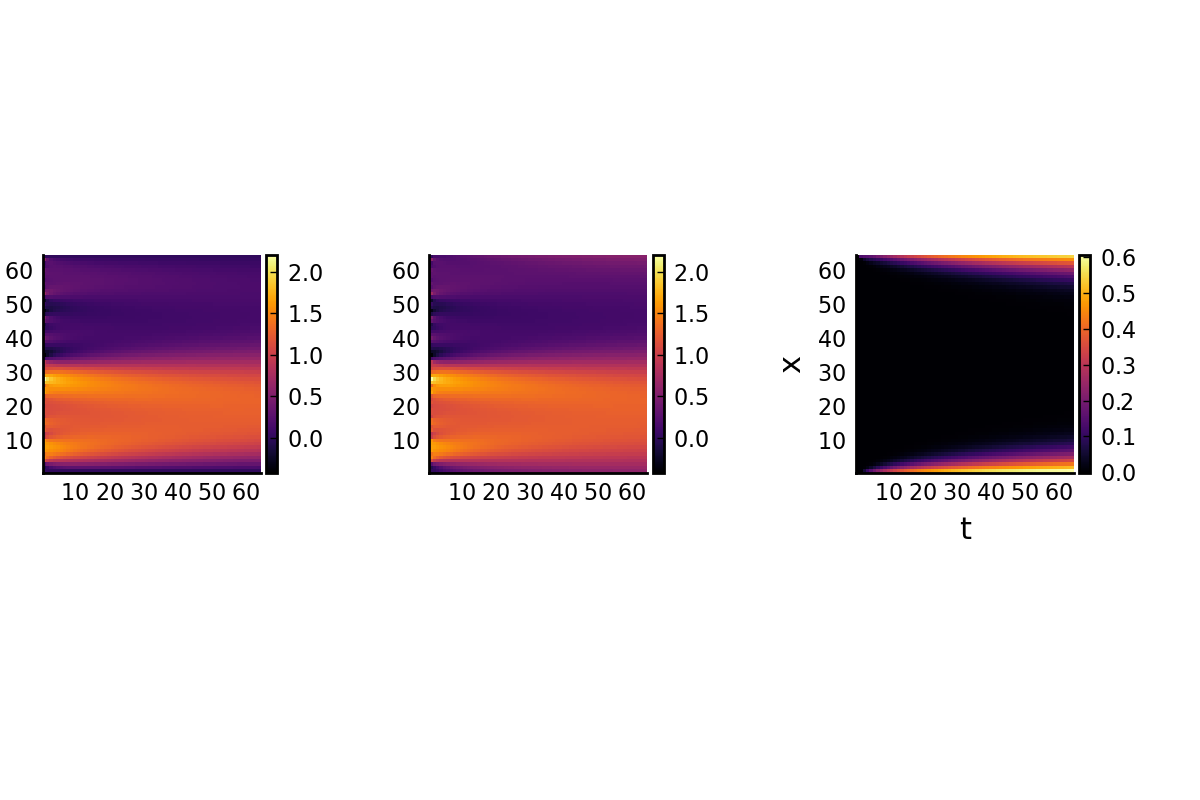

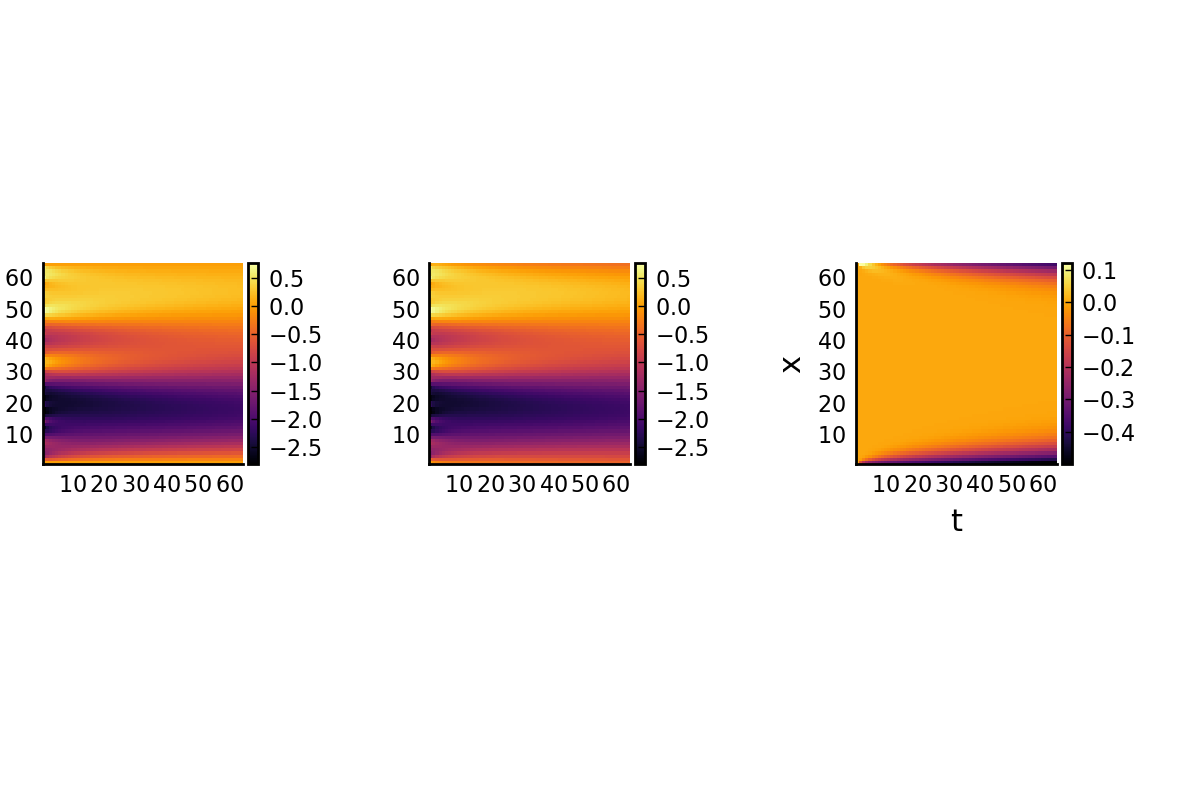

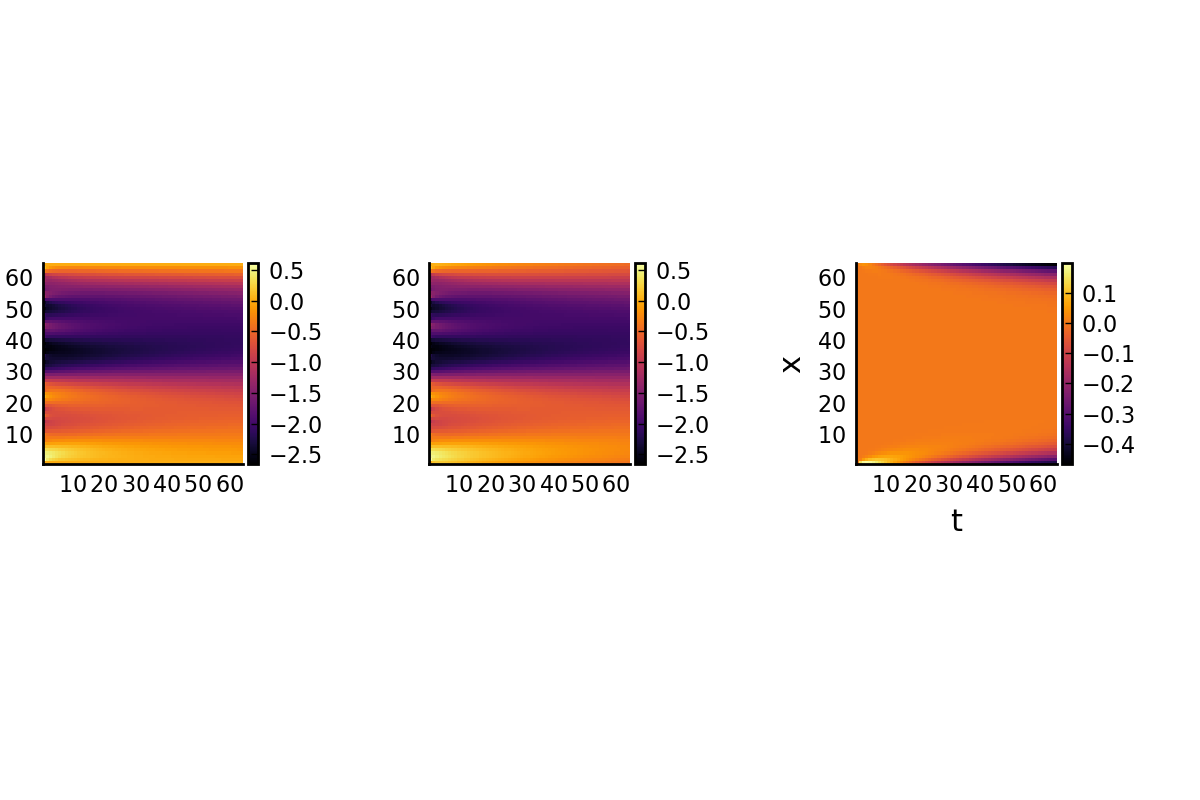

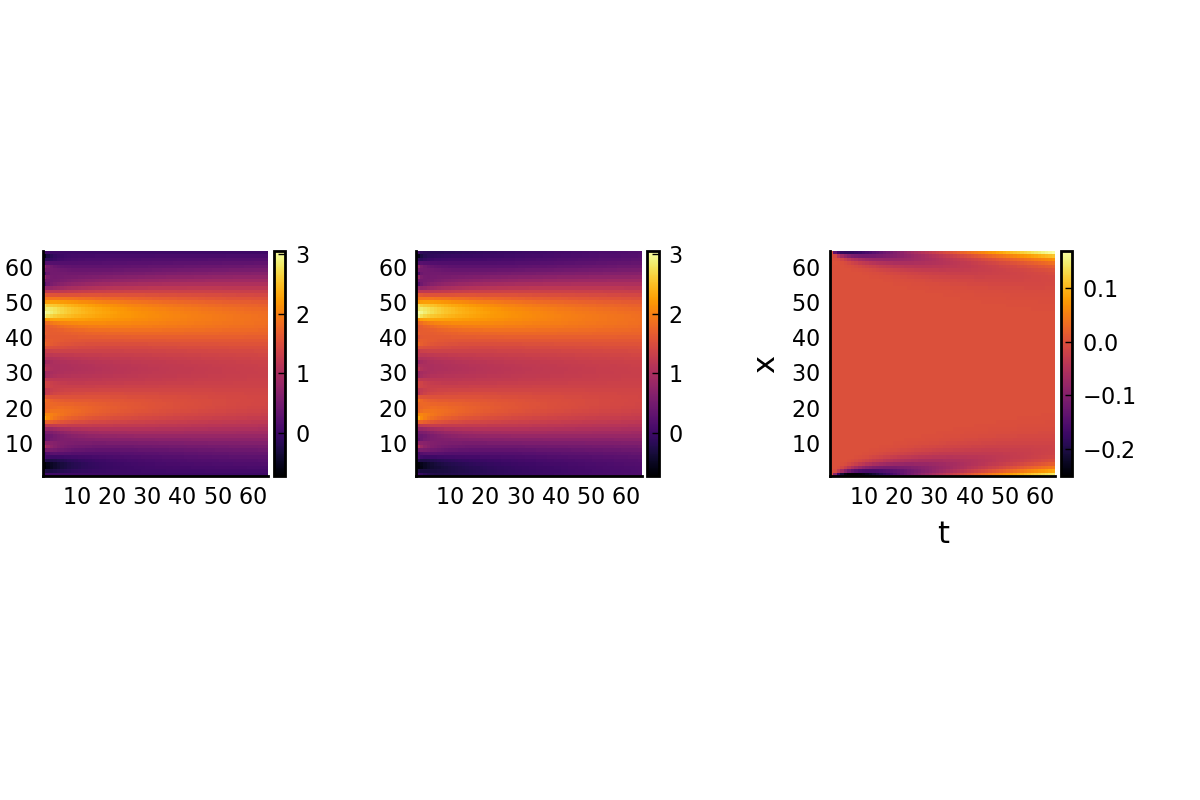

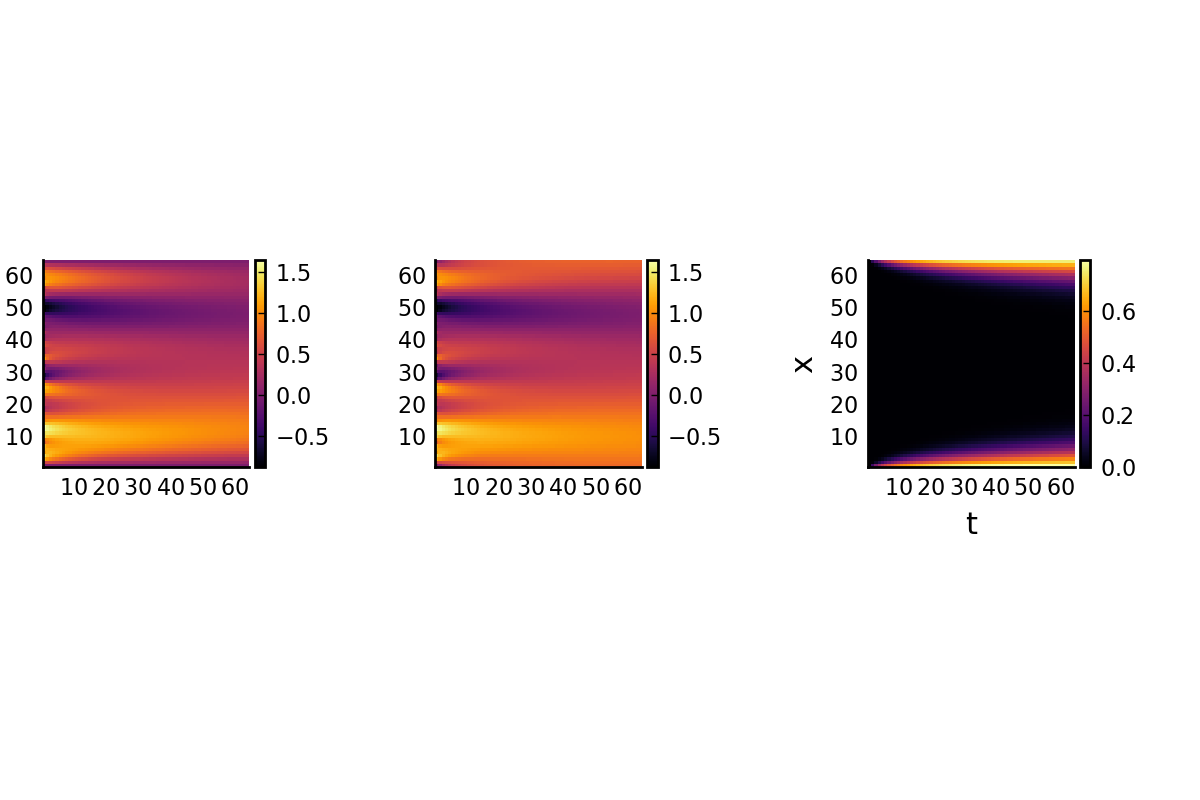

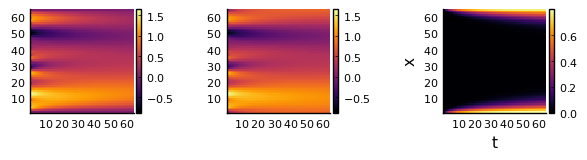

In [67]:
function check_training_dataset(dataset)
    for i in range(1, 5, step=1)
        a, b, _, d = dataset[i];
        _, c = Equations.get_heat_fft(a, dx, x_n, kappa, b[:, 1]);    
        display(
            plot(
            # GraphicTools.show_err(b, d, ""),
            GraphicTools.show_state(b, ""),
            GraphicTools.show_state(c, ""),
            GraphicTools.show_err(c, b, "", "t", "x");
            layout = (1, 3),
            );
        );
    end
end

check_training_dataset(merde_dataset)

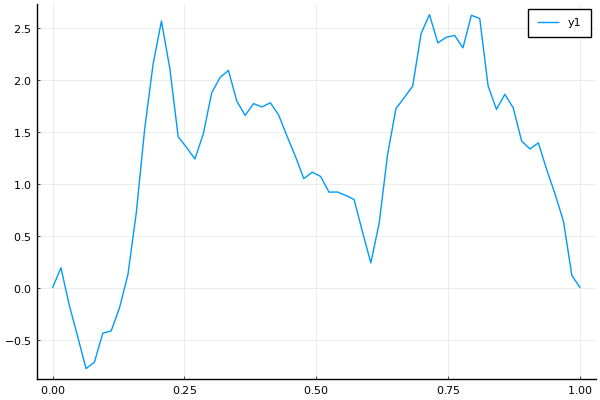

In [243]:
plot(x, init_set[:, 1];)

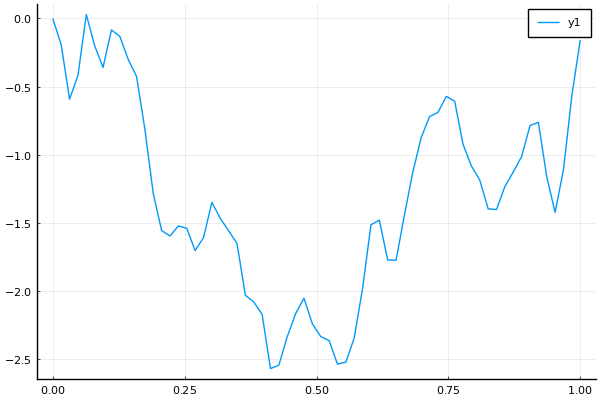

In [244]:
t, u0, u_true = ProcessingTools.process_dataset(analytic_dataset)
plot(x, u0[:, 1];)

---
# Operator reconstruction 

## Early training test

In [164]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset);
loss(A, u₀, uₜ, t) = sum(abs2, S(A, u₀, t) - uₜ) / prod(size(uₜ));
loss(A) = loss(A, init_set, true_set, t);
A = zeros(x_n, x_n);
callback(A, loss) = (println(loss);flush(stdout);false);
result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = 1000);
K = result.u;

LinRange{Float64}Matrix{Float64}Array{Float64, 3}0.4044569262357644
0.3427409932392511
0.2976922431014824
0.262499588425363
0.2338509443941934
0.20995623352095952
0.18969387161293028
0.17227821810924823
0.15712893429665092
0.1438109633217468
0.13200547341036334
0.12148933356450893
0.11211102296768183
0.10375795528645
0.09632677220111961
0.08971192138881473
0.08381131254979432
0.07853748045670607
0.07381557515644582
0.06957500735562158
0.06575758202549492
0.062318437728146256
0.05920643557326161
0.056371822088531386
0.05377885036076323
0.05138698321216992
0.04916356637465011
0.047103086080475295
0.04520156509438315
0.04344492551069397
0.04181873691366325
0.04031373692522376
0.038921079507780926
0.037626760678394704
0.03641814873342772
0.0352853880854901
0.03422064685721896
0.03321835436504086
0.03227271979000571
0.031382060572907475
0.030543962097870157
0.02975122193271583
0.029000234231226097
0.02828592594256933
0.02760239342225783
0.026948615012402283
0.026324502429980457
0.0257293067

0.0023505586049148625
0.002341995464798855
0.002333588157481429
0.002325964650152537
0.002317972220209576
0.0023096145029040684
0.002301803042297395
0.0022941715511118365
0.0022861436987787727
0.0022781973607163882
0.002270627846963156
0.002262990056366362
0.0022551560336941264
0.0022475009458727646
0.0022400578020203487
0.0022325200856503744
0.0022249049300245953
0.002217451805933116
0.002210128229569624
0.002202743347151862
0.0021953253105935692
0.002188032451535653
0.0021808414691263257
0.002173620783429609
0.0021663838643207717
0.0021592357835092087
0.0021521770461607596
0.0021451228065087666
0.0021380583584117725
0.002131049204025475
0.002124118569821562
0.0021172209537223996
0.0021103268022862444
0.0021034603543084434
0.002096652316481417
0.0020898954039479754
0.0020831629980034012
0.002076448980131156
0.0020697693478041036
0.0020631366592224333
0.0020565462853620923
0.002049985180692453
0.00204344833050028
0.0020369422428561045
0.00203047493473308
0.0020240473010195927
0.0020176

0.0009315842115365769
0.0009298757697272078
0.0009281838672717135
0.0009264887617086517
0.0009248051414874755
0.0009231229682095093
0.0009214476687521936
0.000919777522437918
0.0009181115261120624
0.0009164524537685019
0.000914795953863304
0.0009131477965227446
0.000911500824466268
0.0009098630388465514
0.0009082259516654279
0.0009065981672501688
0.0009049708894004697
0.0009033530118915622
0.0009017355831078931
0.000900127334819247
0.0008985197390473235
0.0008969210599530404
0.0008953231183081203
0.0008937339349753614
0.0008921456398479133
0.0008905657819164596
0.000888987075997104
0.0008874164782587789
0.0008858472607192903
0.0008842857964427589
0.0008827260578838923
0.0008811736093729294
0.0008796232681080946
0.0008780797662453799
0.0008765387582151527
0.0008750040987605303
0.0008734723367594072
0.0008719464885284952
0.0008704238624577652
0.0008689067597060026
0.0008673931920250773
0.0008658847834015942
0.0008643801595630755
0.0008628804038961777
0.000861384641339876
0.00085989347822

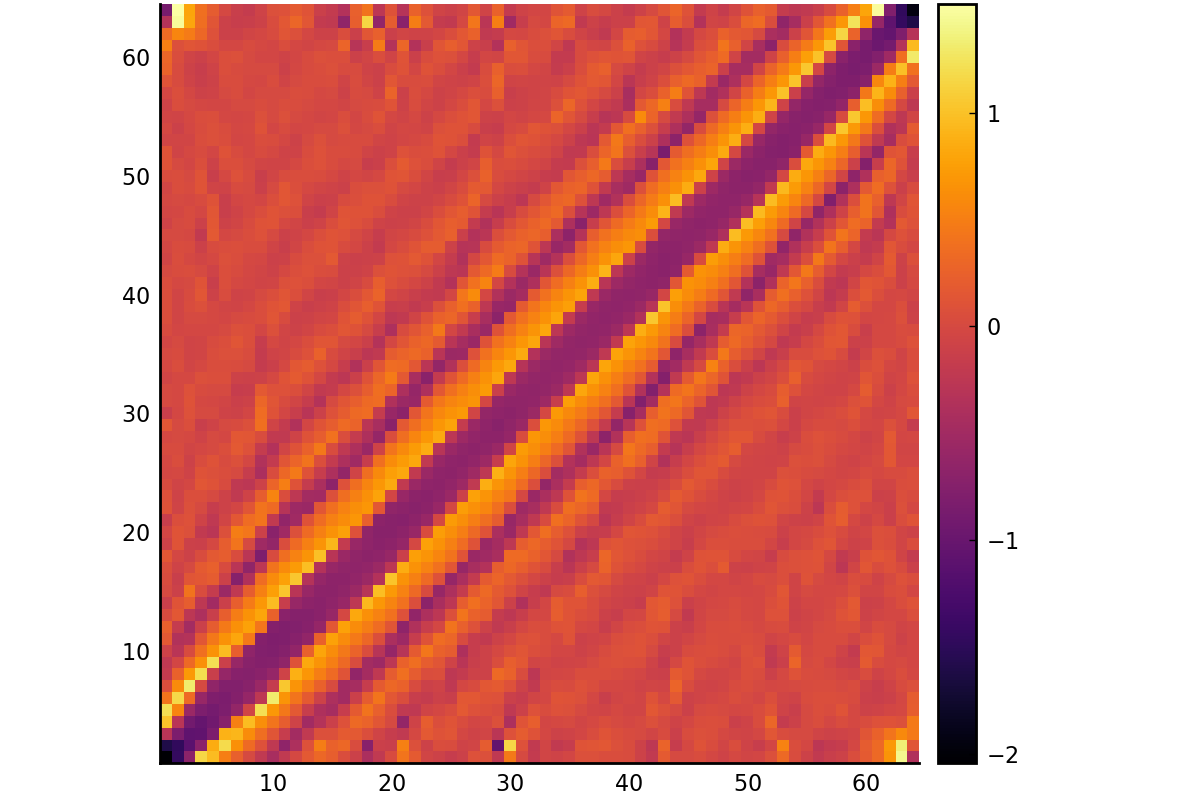

In [166]:
GraphicTools.show_state(K, "")

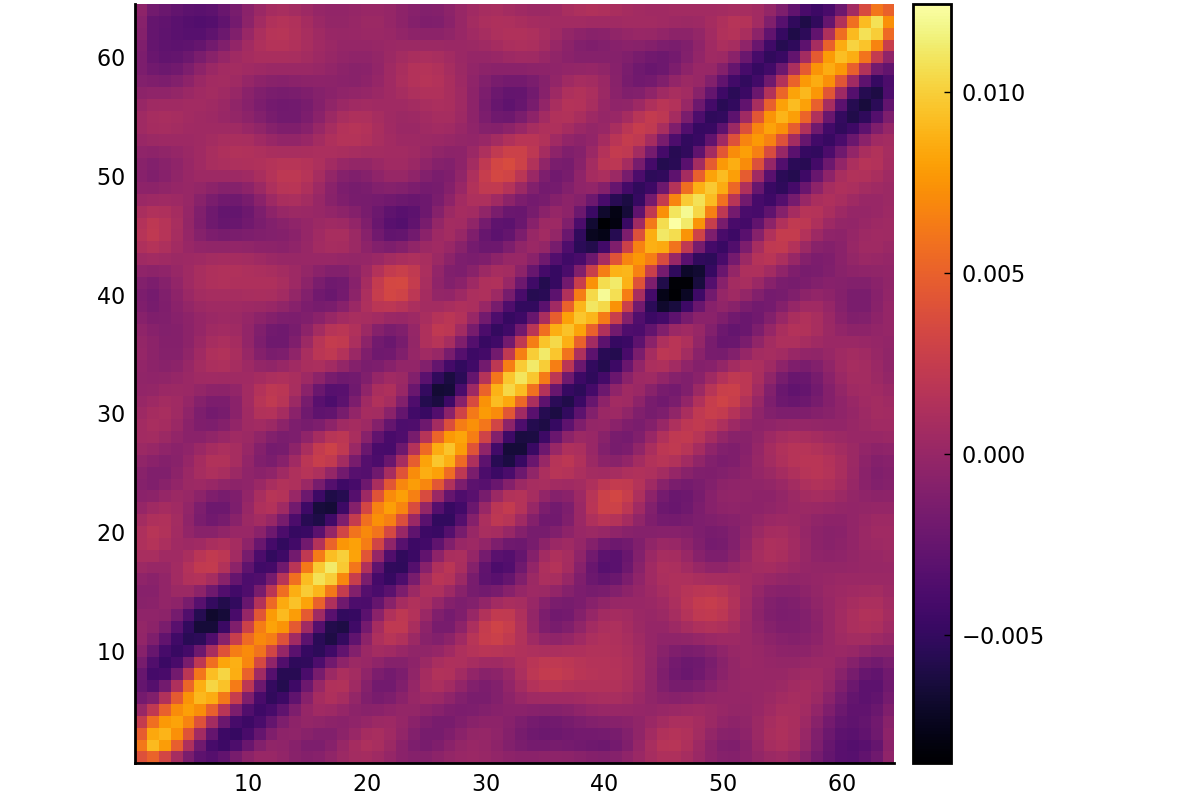

In [167]:
∂L∂K = first(Zygote.gradient(loss, A))
GraphicTools.show_state(∂L∂K, "")

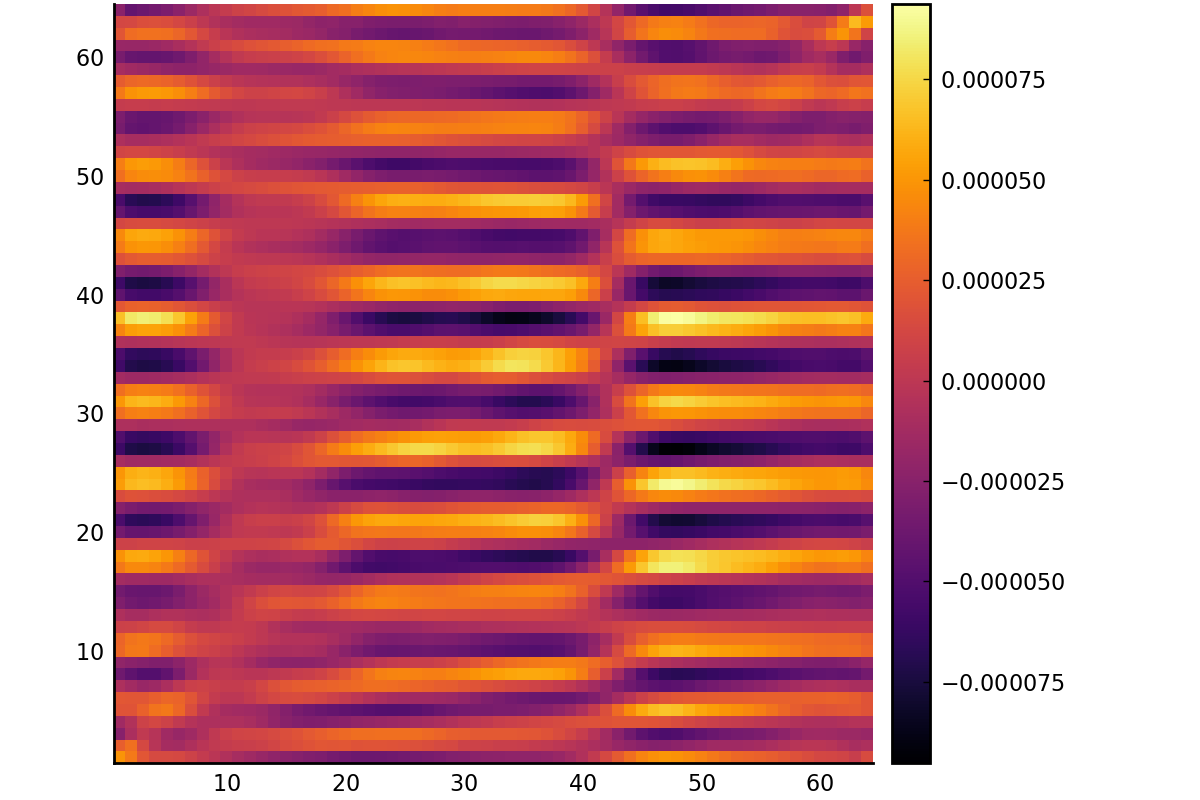

In [176]:
dLdK = first(Zygote.gradient(loss, result.u))
GraphicTools.show_state(dLdK, "")

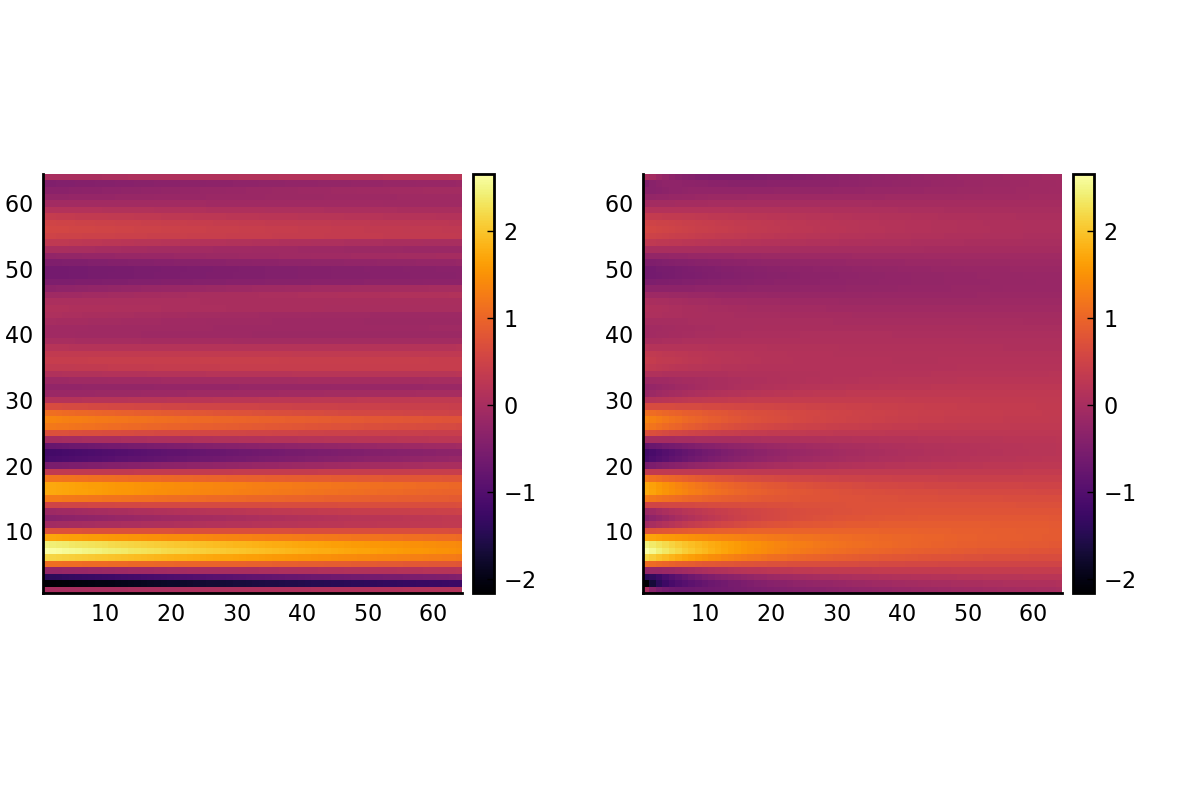

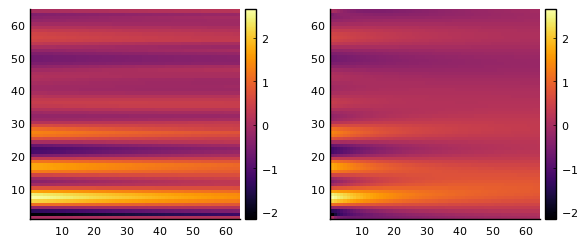

In [214]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 2, kappa, k);
# t, u0, u = syver_dataset;
u_pred = Array(S(K, u0, t));

display(
    plot(
        GraphicTools.show_state(u_pred, ""),
        GraphicTools.show_state(u, "");
        layout = (1, 2),
    );
);

## Training with NeuralODE object

In [177]:
callback(theta, loss, u) = (IJulia.clear_output(true); display(loss); false)

callback (generic function with 2 methods)

In [178]:
function heat_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.01, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-8 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end
    
  # lossL2(K) = loss(K) + 1e-2 * sum(abs2, K) / prod(size(K))

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

heat_training (generic function with 1 method)

In [180]:
t, init_set, true_set = ProcessingTools.process_dataset(hand_dataset);
net = Models.HeatModel(x_n);
result = heat_training(net, 100, init_set, true_set, t);

0.025424600530257694

### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

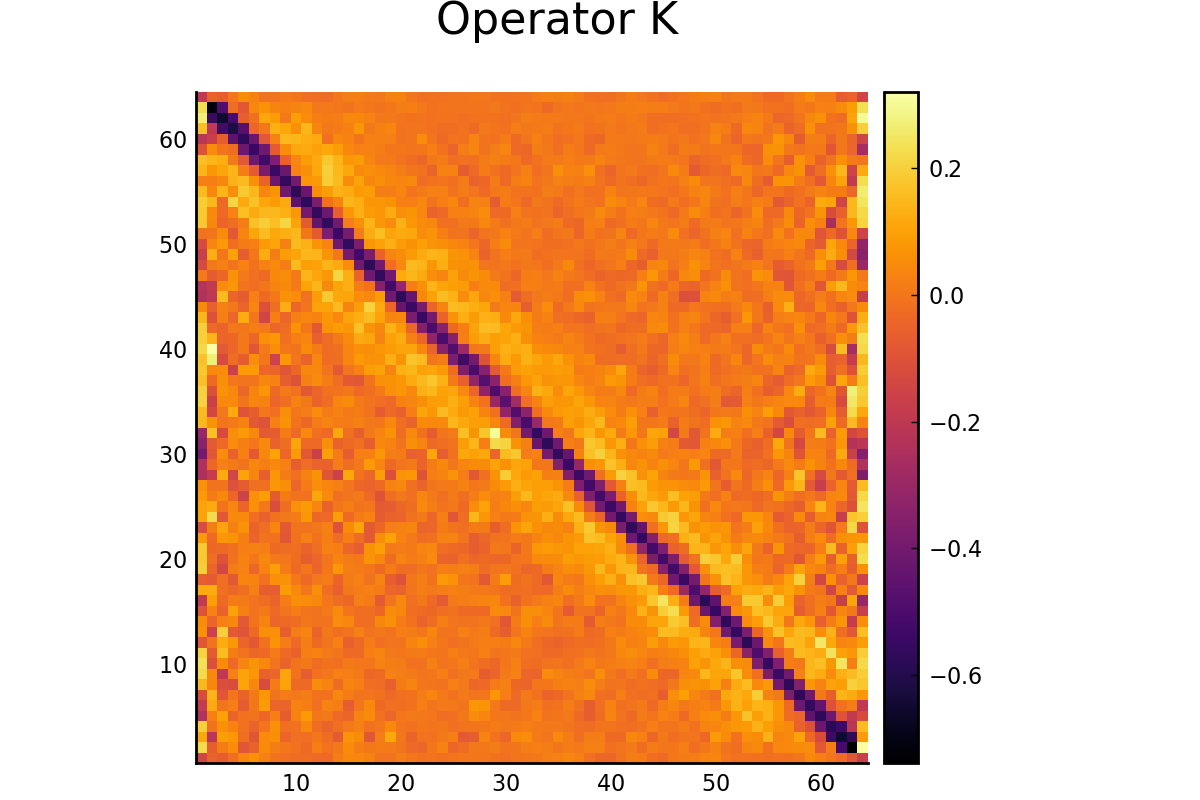

In [181]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

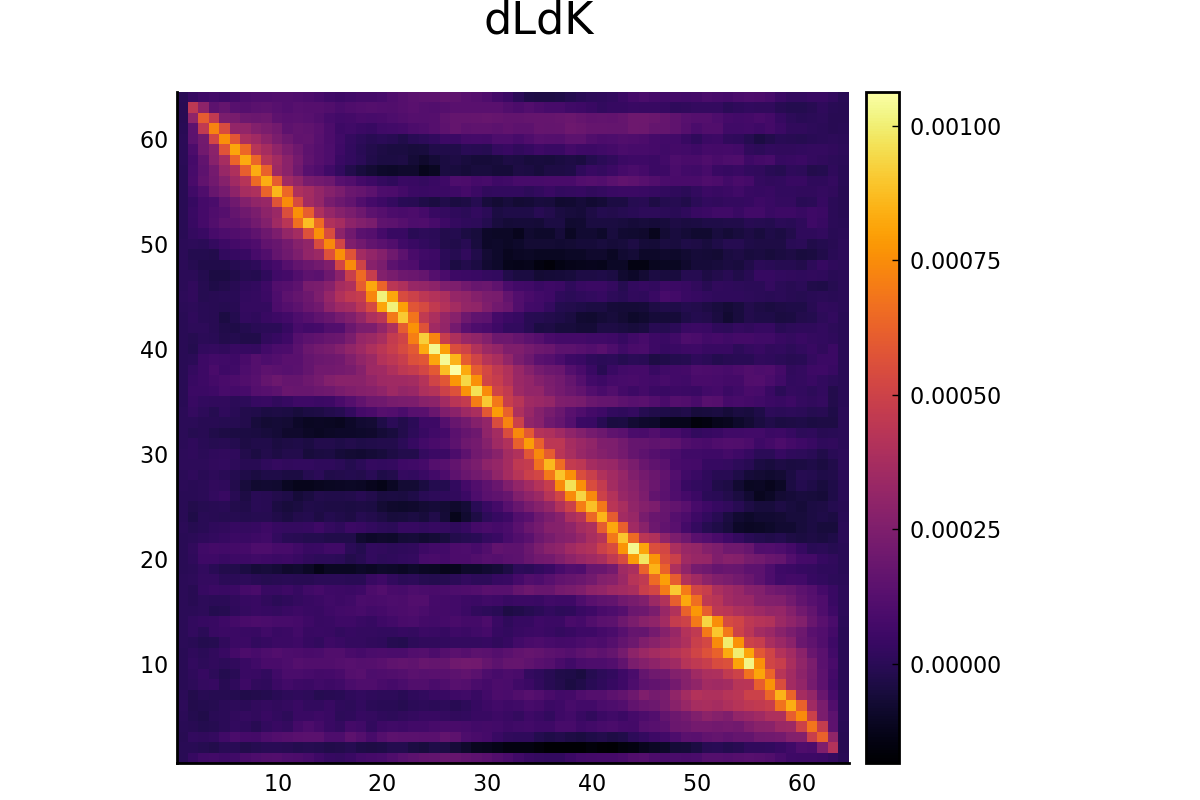

In [218]:
dLdK = first(Zygote.gradient(loss, K))
GraphicTools.show_state(reverse(dLdK; dims=1), "dLdK")

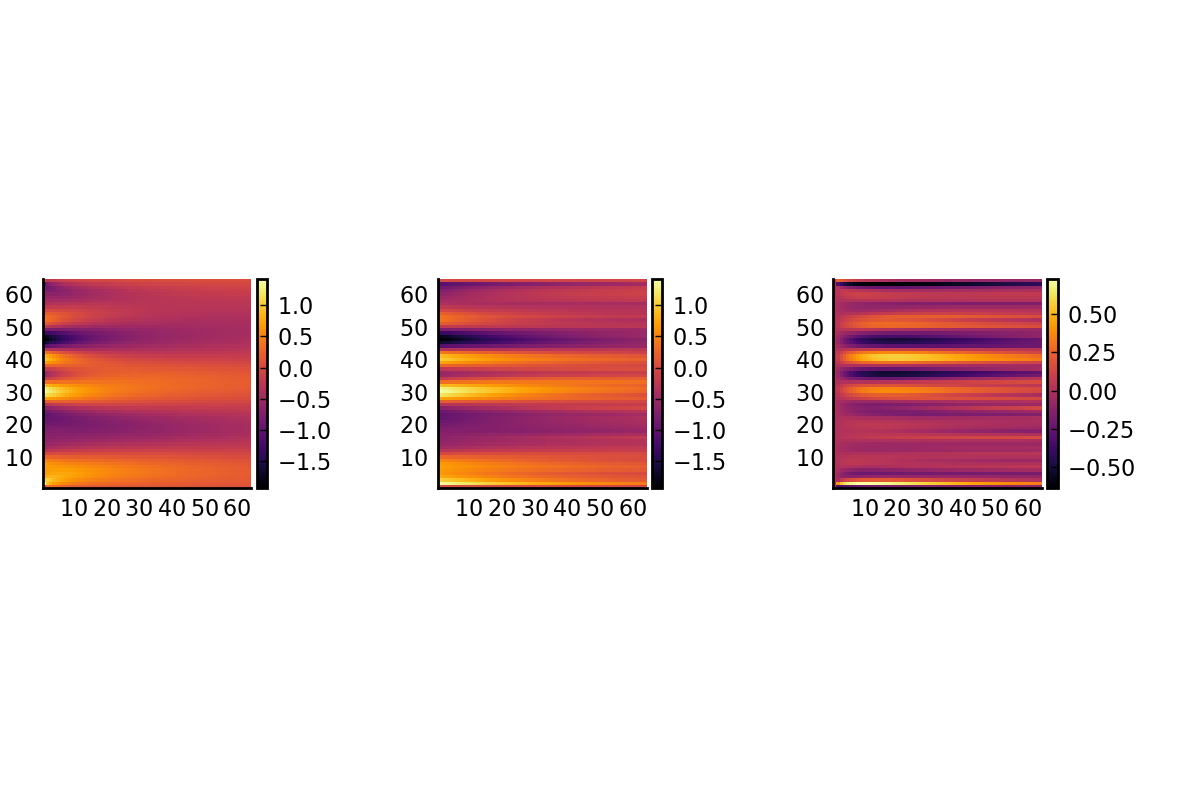

In [224]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 2, kappa, k);
u_pred = Array(S(K, u0, t));

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

---

## Training with solver

In [227]:
function f(u, K, t)
  return K * u
end

f (generic function with 1 method)

In [245]:
function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

S (generic function with 1 method)

In [246]:
callback(A, loss) = (println(loss); flush(stdout); false)

callback (generic function with 2 methods)

In [247]:
function heat_training_solver(A, epochs, u0, u_true, tsnap)
    
  function loss(A)
    u_pred = Array(S(A, u0, tsnap))
    l = Objectives.mseloss(u_pred, u_true)
    return l
  end

  result = DiffEqFlux.sciml_train(loss, A, ADAM(0.01); cb = callback, maxiters = epochs);
  return result
end

heat_training_solver (generic function with 1 method)

In [248]:
net = zeros(x_n, x_n);

### Train with different data sets

Hand (data obtained from analytical solution), analytical (analytical solution at t=0 + ode solver), high dimension data set (from burgers to generate shock).

In [271]:
t4, u04, u_true4 = ProcessingTools.process_dataset(hand_dataset);
result_5 = heat_training_solver(copy(net), 100, u04, u_true4, t4);


0.13316253762356595
0.14389294514127227
0.11999800652777001
0.11446528966224895
0.11004820525498973
0.10241894833804381
0.09507813337647633
0.09121145971252467
0.08921906951857521
0.08655719509737465
0.08259652958402411
0.07827719684589685
0.0749138303678956
0.07303396669051919
0.07179656945119801
0.07012739166335819
0.06781492891747506
0.0653319610423947
0.063315302718024
0.06199438920255422
0.060957951187356176
0.05974030312382528
0.05832345437059606
0.056862868572742774
0.055501446025727236
0.054399742415575804
0.053520380817282505
0.052634869221384314
0.05168512123088349
0.05073782586842028
0.04979685115682566
0.048910100836259504
0.04814063546959968
0.047440945373624296
0.04674439858309808
0.04604796021427638
0.04535447679780646
0.044666779023874066
0.04402204105287627
0.043436508144179875
0.04288481040180935
0.04234799662379052
0.04180818983059507
0.0412561156656181
0.04072284904768311
0.040238985782957835
0.03979040789513911
0.039341763422286694
0.03888340457774216
0.03843554763

In [250]:
t, u0, u_true = ProcessingTools.process_dataset(analytic_dataset);
result_2 = heat_training_solver(copy(net), 100, u0, u_true, t);


0.10744888650831078
0.12768373247565085
0.0966961994944435
0.09401384944698774
0.08985662753056084
0.0820921271045919
0.07455493847825512
0.07003460546468873
0.06847583461484547
0.06695205540220263
0.06343348450146455
0.0587876801647524
0.05547745709016989
0.05451737381128919
0.05409098430781426
0.05215291834121788
0.04924640658192175
0.04706006982672013
0.04598537529050725
0.045288763037794624
0.04430554445847444
0.04287184058714036
0.04132138754634941
0.04017328162438341
0.03950730541923565
0.03891993336263254
0.0381135810047753
0.03714474599212804
0.036216501440479665
0.03548125669416698
0.03490364837493064
0.03431886058208787
0.0336573334495776
0.032990692539533385
0.03238384258109554
0.03184488928263712
0.03135305621201092
0.03085765414529313
0.03034940702264277
0.029878120060919854
0.0294449669756301
0.029007476564156254
0.02857324394548614
0.028177914954397774
0.02781795330582932
0.027450688667606193
0.027066041104038895
0.026704193569901225
0.0263815868640848
0.0260750319157880

In [264]:
t2, init, train = syver_dataset;
result_3 = heat_training_solver(copy(net), 1000, init, train, t2);


0.15242432488328944
0.10980601570835531
0.08314106992491849
0.060706886635805854
0.04403286343339023
0.03487012516892514
0.027431604792909375
0.02423048176425973
0.02489607113081882
0.02383752443726051
0.019413256229830554
0.015156051832866214
0.014286244957622127
0.016061964900522446
0.017246513683011517
0.016424985162409256
0.014484403244044559
0.012697726396248317
0.012218862136886268
0.013136080865553179
0.013986251566651573
0.013518516019433944
0.012194488612621889
0.011358422242999898
0.011446980619427519
0.011689436377405351
0.011482264238194291
0.011018372023017958
0.010665743173964164
0.010440046770753367
0.010067569228076372
0.009566163696950108
0.009242632057967121
0.009177610054751893
0.00912360910920791
0.008790795349059058
0.008275568697778592
0.007934009233955796
0.00785077995496555
0.007777645614600549
0.007610428255557741
0.007392148635654535
0.007144704988641292
0.006956976090509649
0.00686293834389717
0.006780546828031533
0.006666273628789728
0.00654319712656681
0.00

0.0015272875075314231
0.0015142402131645151
0.0015141721505381595
0.0015210871276579558
0.0015268184663522933
0.001525603123586864
0.0015164509230164193
0.0015027585189383193
0.0014899487394363364
0.0014824682168754631
0.0014813157616256427
0.0014838779195828961
0.0014860152808392085
0.0014848217377768718
0.0014800289320093217
0.0014733527239426762
0.0014668611405639074
0.0014619479946859973
0.0014589954342064337
0.0014576956939114955
0.0014571991195932127
0.0014566924295910662
0.001455550763474336
0.001453835514762063
0.0014516400416302727
0.0014491886549973995
0.0014463524060207948
0.0014432935619786028
0.0014401747162432422
0.001437438764773425
0.001435036693781395
0.0014327536560405775
0.0014299269806231224
0.0014263669977026818
0.0014221848178564544
0.0014181007979851329
0.0014147854489593033
0.0014126592806594919
0.001411765796712271
0.0014118716300934508
0.0014129285617174483
0.0014148422279318586
0.001417952536127026
0.0014221564645389244
0.0014277568130889613
0.001434042869936

0.0009286695856513382
0.0009242105802037346
0.0009184179825356773
0.0009177725497557007
0.0009209437001441016
0.0009219754532149303
0.0009191808656873637
0.000917004015356376
0.0009192251223639695
0.0009248023433889688
0.0009306985132286267
0.0009375479472390398
0.0009492789700808736
0.0009709076684779218
0.0010043391131560428
0.0010549133754865724
0.0011245504057802013
0.0012253527059463744
0.0013422681981347872
0.0014725795649119951
0.0015384320578964846
0.0015227715352590667
0.0013593882317495657
0.00114543805764462
0.0009768534766525093
0.0009501063915210331
0.0010387958863876427
0.0011278330112364458
0.0011252915378331702
0.001033346748194576
0.0009488598097598056
0.0009365990506065068
0.0009710067760937224
0.000986848140421213
0.0009585958079647266
0.0009248738908387165
0.0009212949535783658
0.0009370871285281685
0.000940885664487749
0.000923749597450955
0.0009082710217027314
0.0009094986236405687
0.0009168652202060127
0.0009136697589462083
0.0009001246456122653
0.000891154118268

In [254]:
t3, u03, u_true3 = ProcessingTools.process_dataset(high_dataset);
result_4 = heat_training_solver(copy(net), 100, u03, u_true3, t3);


0.4044569262357644
0.3427409932392511
0.2976922431014824
0.262499588425363
0.2338509443941934
0.20995623352095952
0.18969387161293028
0.17227821810924823
0.15712893429665092
0.1438109633217468
0.13200547341036334
0.12148933356450893
0.11211102296768183
0.10375795528645
0.09632677220111961
0.08971192138881473
0.08381131254979432
0.07853748045670607
0.07381557515644582
0.06957500735562158
0.06575758202549492
0.062318437728146256
0.05920643557326161
0.056371822088531386
0.05377885036076323
0.05138698321216992
0.04916356637465011
0.047103086080475295
0.04520156509438315
0.04344492551069397
0.04181873691366325
0.04031373692522376
0.038921079507780926
0.037626760678394704
0.03641814873342772
0.0352853880854901
0.03422064685721896
0.03321835436504086
0.03227271979000571
0.031382060572907475
0.030543962097870157
0.02975122193271583
0.029000234231226097
0.02828592594256933
0.02760239342225783
0.026948615012402283
0.026324502429980457
0.025729306729039378
0.025163952666537478
0.02462692152816786

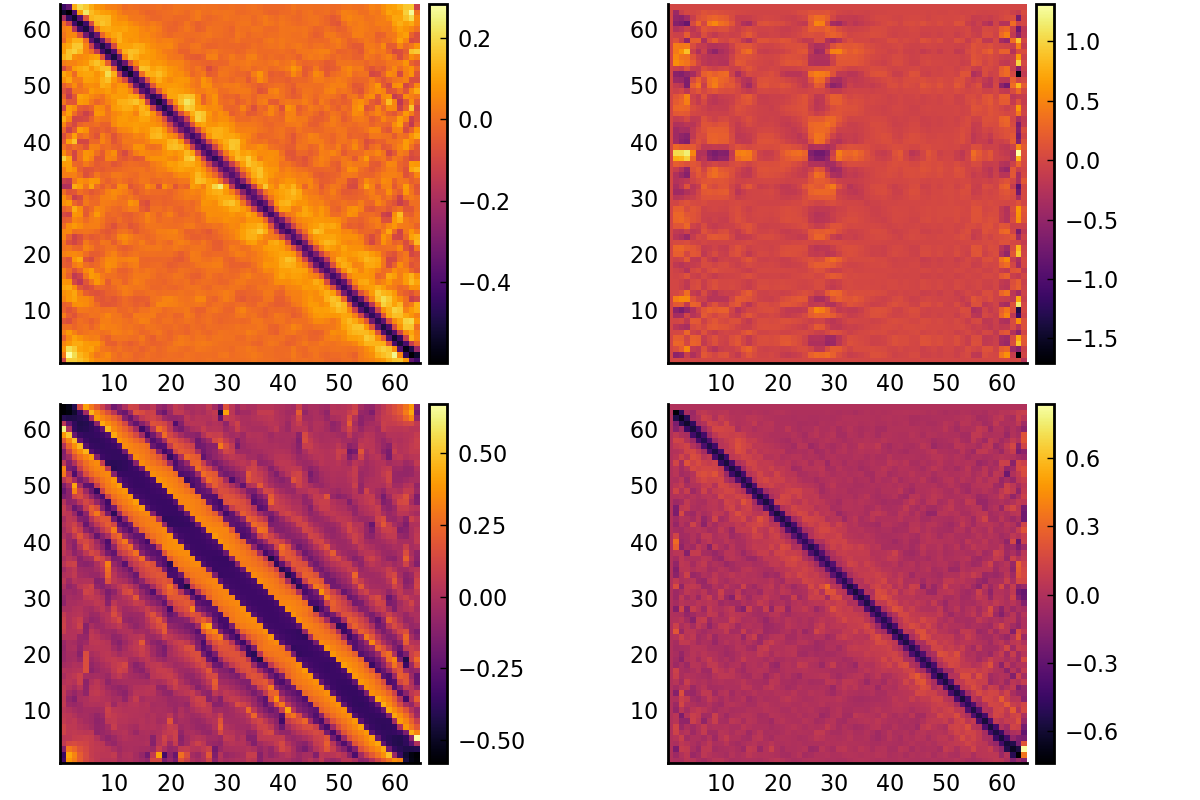

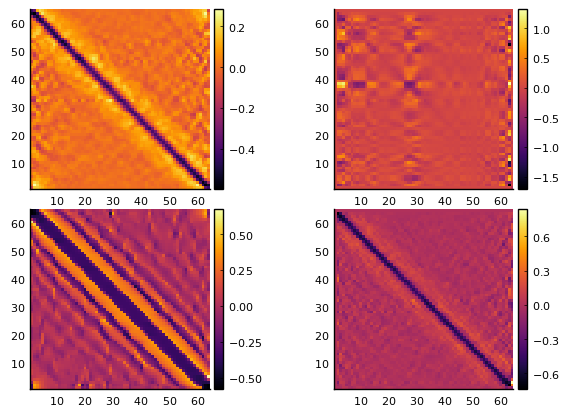

In [307]:
K2 = result_2.u
K3 = result_3.u;
K4 = result_4.u;
K5 = result_5.u;

display(
    plot(
        GraphicTools.show_state(reverse(K2; dims = 1), ""),
        GraphicTools.show_state(reverse(K3; dims = 1), ""),
        GraphicTools.show_state(reverse(K4; dims = 1), ""),
        GraphicTools.show_state(reverse(K5; dims = 1), "");
        layout = (2, 2),
    ),
);  

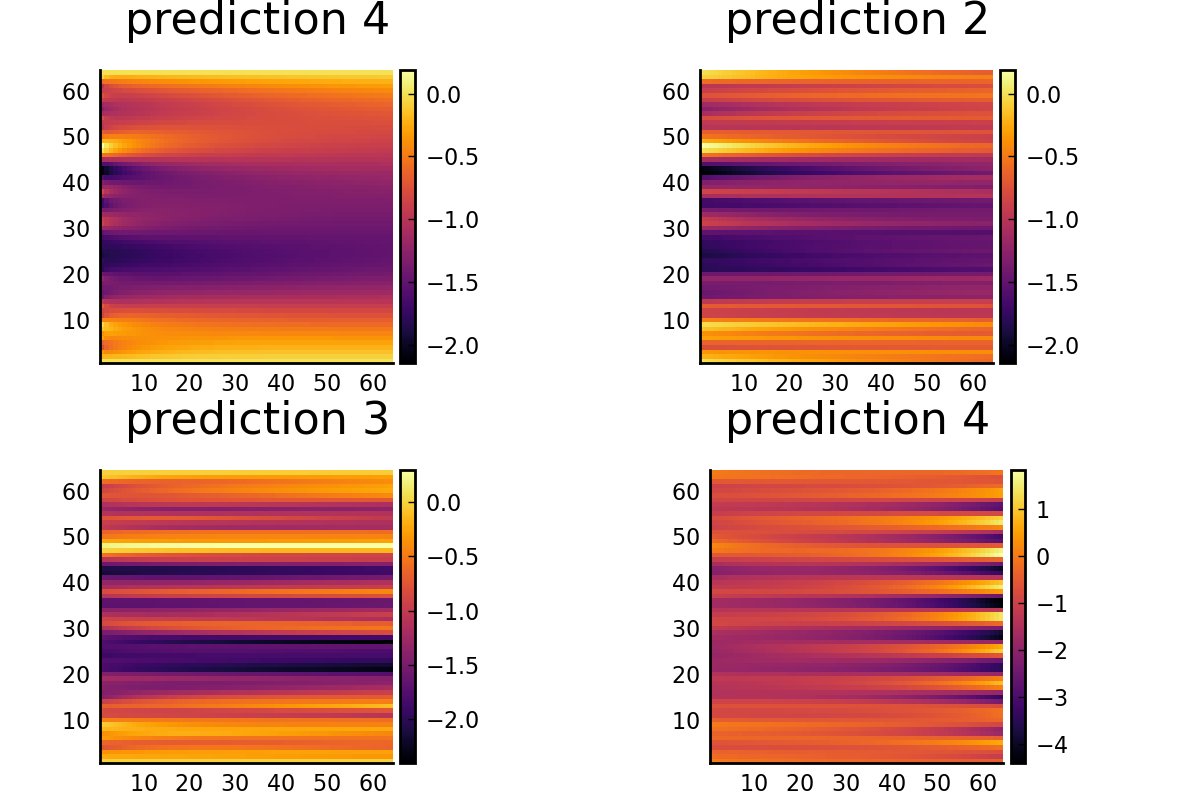

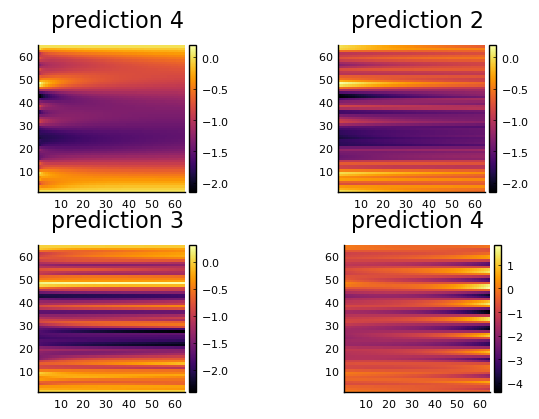

In [297]:
t, u0, u = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, 4, kappa, k);
u_pred_2 = Array(S(K2, u0, t));
u_pred_3 = Array(S(K3, u0, t));
u_pred_4 = Array(S(K4, u0, t));

display(
    plot(
        GraphicTools.show_state(u, "data"),
        GraphicTools.show_state(u_pred_2, "prediction 2"),
        GraphicTools.show_state(u_pred_3, "prediction 3"),
        GraphicTools.show_state(u_pred_4, "prediction 4");
        layout = (2, 2),
        reuse = false
    ),
);

In [288]:
function test_simulation(net, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_heat_batch(t_max, t_min, x_max, x_min, t_n, x_n, typ, kappa, k);
        u_pred = Array(S(net, u0, t));
        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

test_simulation (generic function with 2 methods)

In [303]:
println(test_simulation(K2, 100, 1))
println(test_simulation(K2, 100, 2))
println(test_simulation(K2, 100, 3))
println(test_simulation(K2, 100, 4))

(0.0004783739086972137, 7.184452879437999)
(0.0007862835293717015, 9.64128593018158)
(0.00039722933307677745, 6.422106748520637)
(0.00024164655472006243, 5.00322502694444)


In [304]:
println(test_simulation(K3, 100, 1))
println(test_simulation(K3, 100, 2))
println(test_simulation(K3, 100, 3))
println(test_simulation(K3, 100, 4))

(0.0006422311475640131, 8.572645501405955)
(0.00454968502843881, 22.0555803755563)
(0.0016090135838523528, 13.115922558443994)
(0.000847272494368121, 9.354638390171797)


In [305]:
println(test_simulation(K4, 100, 1))
println(test_simulation(K4, 100, 2))
println(test_simulation(K4, 100, 3))
println(test_simulation(K4, 100, 4))

(0.0012013679039818074, 11.110506780658675)
(0.0002714480861071529, 5.404198110718221)
(0.0036621258338980123, 17.764753011738552)
(0.0018427367965608082, 12.837314911372818)
